In [19]:
import numpy as np
import pandas as pd
from rdkit import Chem
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import confusion_matrix

In [20]:
clintox_df = pd.read_csv("clintox.csv")

# Preprocess SMILES strings
clintox_df['Molecule'] = clintox_df['smiles'].apply(Chem.MolFromSmiles)

# Tokenize SMILES strings
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(clintox_df['smiles'])
max_len = max(len(smiles) for smiles in clintox_df['smiles'])
X_seq = tokenizer.texts_to_sequences(clintox_df['smiles'])
X_pad = pad_sequences(X_seq, maxlen=max_len)

# Encode labels
y_encoded = clintox_df['FDA_APPROVED'].values

[11:48:24] Explicit valence for atom # 0 N, 5, is greater than permitted
[11:48:24] Can't kekulize mol.  Unkekulized atoms: 9
[11:48:24] Explicit valence for atom # 10 N, 4, is greater than permitted
[11:48:24] Explicit valence for atom # 10 N, 4, is greater than permitted
[11:48:24] Can't kekulize mol.  Unkekulized atoms: 4
[11:48:24] Can't kekulize mol.  Unkekulized atoms: 4


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_pad, y_encoded, test_size=0.2, random_state=42)

LSTM for Clintox dataset

Epoch 1/100
30/30 [==============================] - 5s 116ms/step - loss: 0.2892 - accuracy: 0.9283 - val_loss: 0.2443 - val_accuracy: 0.9412
Epoch 2/100
30/30 [==============================] - 3s 106ms/step - loss: 0.2366 - accuracy: 0.9378 - val_loss: 0.2284 - val_accuracy: 0.9412
Epoch 3/100
30/30 [==============================] - 3s 109ms/step - loss: 0.2368 - accuracy: 0.9378 - val_loss: 0.2300 - val_accuracy: 0.9412
Epoch 4/100
30/30 [==============================] - 3s 113ms/step - loss: 0.2317 - accuracy: 0.9378 - val_loss: 0.2316 - val_accuracy: 0.9412
Epoch 5/100
30/30 [==============================] - 3s 115ms/step - loss: 0.2336 - accuracy: 0.9378 - val_loss: 0.2324 - val_accuracy: 0.9412
Epoch 6/100
30/30 [==============================] - 4s 118ms/step - loss: 0.2353 - accuracy: 0.9378 - val_loss: 0.2324 - val_accuracy: 0.9412
Epoch 7/100
30/30 [==============================] - 3s 110ms/step - loss: 0.2271 - accuracy: 0.9378 - val_loss: 0.2329 - val_accuracy: 0.9412

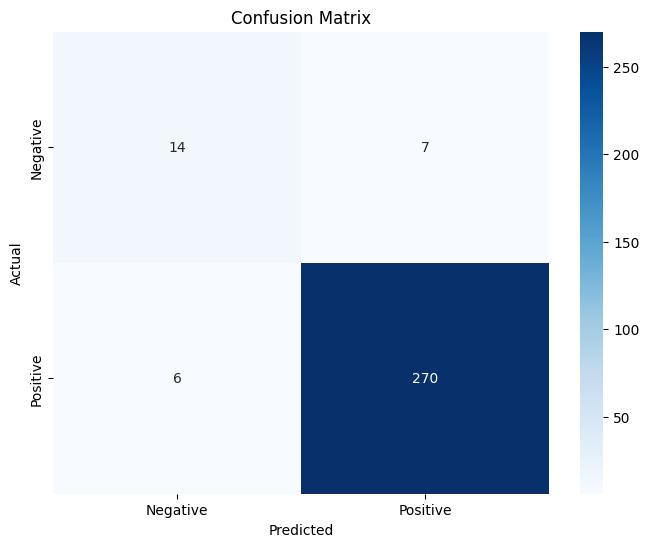

In [24]:
model = Sequential()
model.add(LSTM(units=64, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

y_pred_proba = model.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC Score:", roc_auc)

import seaborn as sns
import matplotlib.pyplot as plt
y_pred = (y_pred_proba > 0.5).astype(int)
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [25]:
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=128, input_length=max_len))
model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
model.add(Bidirectional(LSTM(units=32)))
model.add(Dense(units=1, activation='sigmoid'))

In [26]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
30/30 [==============================] - 17s 341ms/step - loss: 0.3311 - accuracy: 0.9136 - val_loss: 0.2214 - val_accuracy: 0.9412
Epoch 2/50
30/30 [==============================] - 11s 378ms/step - loss: 0.2240 - accuracy: 0.9378 - val_loss: 0.2067 - val_accuracy: 0.9412
Epoch 3/50
30/30 [==============================] - 15s 507ms/step - loss: 0.1728 - accuracy: 0.9399 - val_loss: 0.1470 - val_accuracy: 0.9454
Epoch 4/50
30/30 [==============================] - 14s 487ms/step - loss: 0.1194 - accuracy: 0.9589 - val_loss: 0.0981 - val_accuracy: 0.9706
Epoch 5/50
30/30 [==============================] - 12s 396ms/step - loss: 0.0954 - accuracy: 0.9715 - val_loss: 0.1070 - val_accuracy: 0.9706
Epoch 6/50
30/30 [==============================] - 9s 316ms/step - loss: 0.1081 - accuracy: 0.9726 - val_loss: 0.0687 - val_accuracy: 0.9790
Epoch 7/50
30/30 [==============================] - 9s 311ms/step - loss: 0.1300 - accuracy: 0.9262 - val_loss: 0.1180 - val_accuracy: 0.9412
E

10/10 [==============================] - 1s 91ms/step - loss: 0.0696 - accuracy: 0.9798
Test Loss: 0.06958544254302979
Test Accuracy: 0.9797979593276978
10/10 [==============================] - 3s 155ms/step
ROC AUC Score: 0.9720496894409938


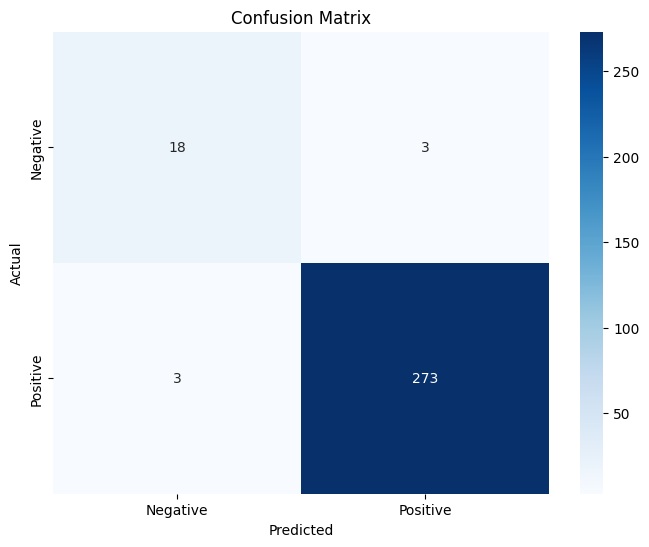

In [27]:
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

y_pred_proba = model.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC Score:", roc_auc)

import seaborn as sns
import matplotlib.pyplot as plt
y_pred = (y_pred_proba > 0.5).astype(int)
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
